In [197]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense, LeakyReLU
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import cross_val_score

# 모델 로드

In [15]:
model = load_model('model.h5')


# 데이터셋 로드

In [139]:
train_path = ''
test_path =  ''

# 데이터 어그멘테이션

## train generator 생성

In [304]:
train_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=False,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     rescale=1./255,
                                     validation_split=0.2)

## train 데이터 생성

In [314]:
train = train_generator.flow_from_directory(train_path,
                                           batch_size=32,
                                           class_mode='binary',
                                           target_size=(96, 96),
                                           color_mode='rgb',
                                           shuffle=True,
                                           subset='training')

Found 1633 images belonging to 2 classes.


## validation 데이터 생성

In [315]:
validation = train_generator.flow_from_directory(train_path,
                                           batch_size=32,
                                           class_mode='binary',
                                           target_size=(96, 96),
                                           color_mode='rgb',
                                           shuffle=True,
                                           subset='validation')

Found 408 images belonging to 2 classes.


## test 데이터 생성

In [316]:
test_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=False,
                                    rescale=1./255,)

test = test_generator.flow_from_directory(test_path,
                                         batch_size=32,
                                         class_mode='binary',
                                         target_size=(96, 96),
                                         color_mode='rgb')

Found 2041 images belonging to 2 classes.


# 모델 설계

In [308]:
mobilenetV2 = MobileNetV2(input_shape=(96, 96, 3),
                          include_top=False,
                          weights='imagenet')

model = Sequential([
    #InputLayer(input_shape=(96, 96, 3)),
    mobilenetV2,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(512, activation=LeakyReLU(alpha=0.2)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation=LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(2, activation='softmax')
    #Conv2D(16, kernel_size=[3, 3], strides=[1, 1], padding='same', activation=LeakyReLU(alpha=0.2)),
    #MaxPool2D([2, 2], [2, 2]),
    #Conv2D(32, kernel_size=[3, 3], strides=[1, 1], padding='same', activation=LeakyReLU(alpha=0.2)),
    #MaxPool2D([2, 2], [2, 2]),
    #Flatten(),
    #Dense(128, activation='relu'),
    #Dense(1, activation='sigmoid')
])

model.layers[0].trainable=False

## 모델 컴파일

In [310]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## 모델 요약

In [311]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 512)               655872    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)             

## 콜백

In [312]:
early_stop= tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

## 모델 학습

In [313]:
hist = model.fit(train,
                 validation_data= validation,
                 epochs=50,
                 callbacks=[early_stop])

Epoch 1/50
52/52 [==============================] - 20s 349ms/step - loss: 1.0751 - accuracy: 0.5720 - val_loss: 1.4160 - val_accuracy: 0.5221
Epoch 2/50
52/52 [==============================] - 17s 336ms/step - loss: 0.7591 - accuracy: 0.6387 - val_loss: 0.9284 - val_accuracy: 0.5221
Epoch 3/50
52/52 [==============================] - 17s 336ms/step - loss: 0.6592 - accuracy: 0.6742 - val_loss: 0.9134 - val_accuracy: 0.5319
Epoch 4/50
52/52 [==============================] - 18s 344ms/step - loss: 0.6153 - accuracy: 0.6938 - val_loss: 0.9457 - val_accuracy: 0.5343
Epoch 5/50
52/52 [==============================] - 17s 336ms/step - loss: 0.5814 - accuracy: 0.7122 - val_loss: 0.8806 - val_accuracy: 0.5539
Epoch 6/50
52/52 [==============================] - 17s 335ms/step - loss: 0.5540 - accuracy: 0.7330 - val_loss: 0.9264 - val_accuracy: 0.5049
Epoch 7/50
52/52 [==============================] - 17s 336ms/step - loss: 0.5215 - accuracy: 0.7471 - val_loss: 0.9175 - val_accuracy: 0.5417

## 라벨 확인

In [297]:
print (test.class_indices)

{'training_fake': 0, 'training_real': 1}


## 모델 평가

In [298]:
score = model.evaluate(validation, verbose=1)
print (score)

13/13 [==============================] - 3s 209ms/step - loss: 0.9152 - accuracy: 0.5147
[0.9152485132217407, 0.5147058963775635]


## 모델 예측


In [299]:
predict = model.predict(test, verbose=1)
print (len(predict))

2041/2041 [==============================] - 16s 8ms/step
2041


# 시각화

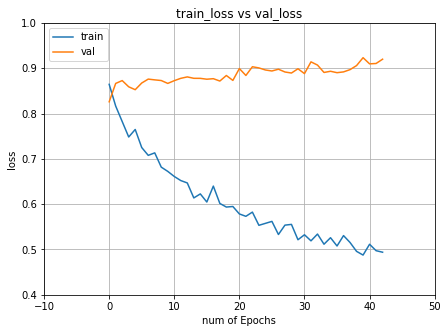

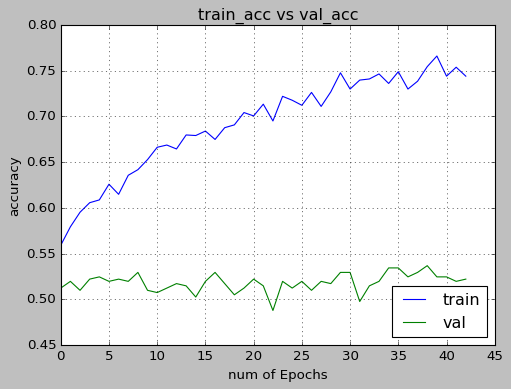

In [302]:
import matplotlib.pyplot as plt
epochs = 43
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [340]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import cv2
size = (96, 96)

def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (96, 96))
    return image[..., ::-1]



test_image = load_img('easy_4_0011.jpg')
#test_image = image.load_img('C:/github_roytravel/roytravel/pattern-recognition/Assignment/test/training_fake/easy_4_0011.jpg')
#test_image = image.smart_resize(test_image, size)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
#print (result)
#print (train.class_indicies)
prediction = ["fake" if result[0][0] == 1 else "real"]
print (prediction[0])


real
